### Import all dependencies

In [1]:
import re
import json
import nltk
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [2]:
ticket_clean = pd.read_csv('tickets_clean.csv')
human_tags_data = pd.read_csv('human_tags.csv')
human_tags_data = human_tags_data.dropna()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
human_tags_data.size,ticket_clean.size

(10128, 4789545)

In [4]:
ticket_clean.head()

,id,title,content,0,1,2,3,4,5,6,7,8,9,lang,title_content
0,808689,adblock plus filter subscription subscription ...,update adblock plus recently late hour late da...,addon|firefox-3616|desktop|firefox-36|windows-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,adblock plus filter subscription subscription ...
1,808690,rid cookie scorecardresearch.com appear list c...,permanently remove scorecardresearch.com uid c...,data|firefox-3616|desktop|firefox-36|windows-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,rid cookie scorecardresearch.com appear list c...
2,808691,firefox 4 open google chat work google,use google chat late download firefox google c...,firefox-40|websites|desktop|windows-vista,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,firefox 4 open google chat work google use goo...
3,808692,history last max 3 day plugin dissaprear close...,wish ff feature punch people internet hard!i'v...,firefox-40|data|desktop|windows-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,history last max 3 day plugin dissaprear close...
4,808693,number verification image ticket site display,try buy ticket line tickets.com ticketmaster e...,firefox-36|websites|firefox-3616|desktop|windo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,number verification image ticket site display ...


In [5]:
human_tags_data.head()

,ticket_url,tags,tagger_id,ticket_id,is_expert,is_sumo
0,https://support.mozilla.org/questions/1277858,config; history; settings; ui,1,1277858,0,0
1,https://support.mozilla.org/questions/1277858,history;how-to-use-firefox,9,1277858,1,0
2,https://support.mozilla.org/questions/1277858,customize;ui,5,1277858,0,0
3,https://support.mozilla.org/questions/1277858,history,2,1277858,0,0
4,https://support.mozilla.org/questions/1277858,history;customization,4,1277858,0,0


In [6]:
temp = human_tags_data[human_tags_data['tags'].str.contains('account')]['ticket_id']

### prepare data for training

In [7]:
all_ticket_ids = ticket_clean['id'].to_numpy()
all_ticket_title_content = ticket_clean['title_content'].to_numpy()
all_ticket_dict = dict(zip(all_ticket_ids,all_ticket_title_content))

In [8]:
ticket_ids = human_tags_data['ticket_id'].to_numpy()
human_tags = human_tags_data['tags'].to_numpy()

In [9]:
tickets = {}
all_human_tags = []
for i,tid in enumerate(ticket_ids):
    if tid in all_ticket_ids:
        tags = str(human_tags[i]).split(';')
        tags = [tag.strip().lower() for tag in tags if len(tag.strip().lower()) > 0]
        all_human_tags.extend(tags)
        if tid in tickets:
            tickets[tid]['tags'].extend(tags)
        else:
            tickets[tid] = {"tags":tags,"title_content":all_ticket_dict[tid]}

### select tags for training

In [10]:
human_tags_fre = Counter(all_human_tags)

In [11]:
candidate_tags = [item[0] for item in human_tags_fre.most_common(50)]

### tag frequency statistics

Text(0, 0.5, 'Frequency')

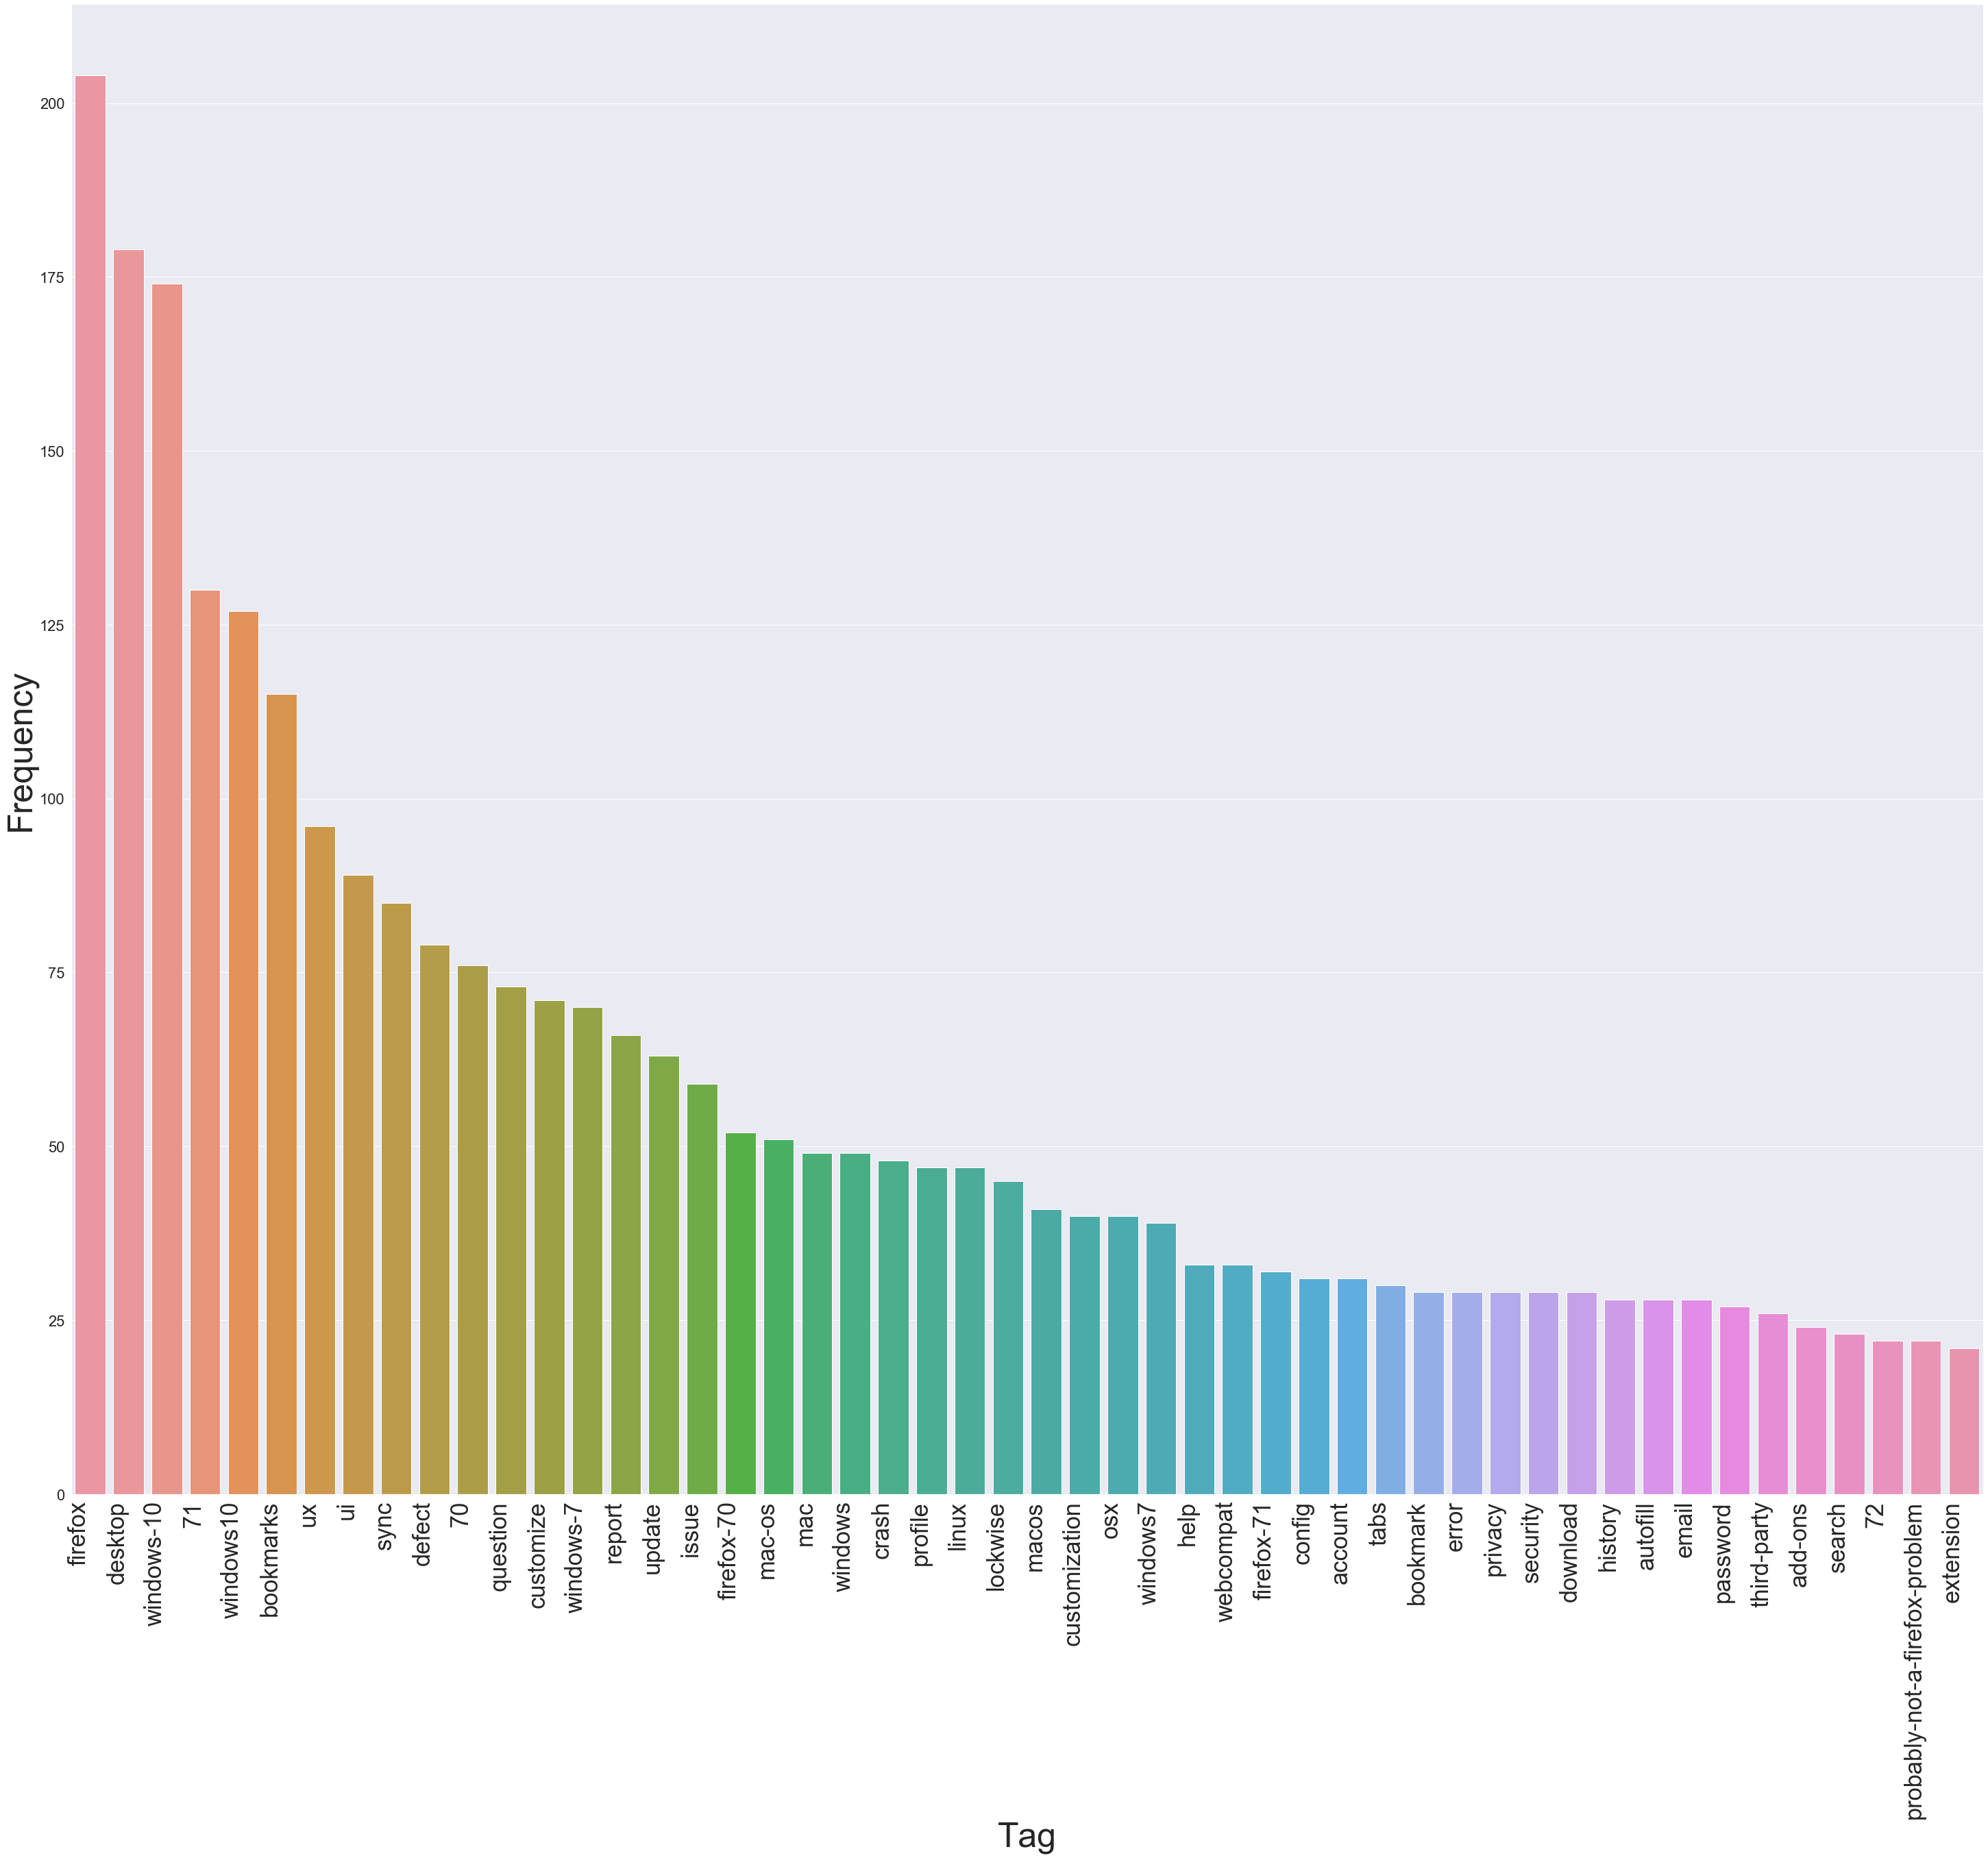

In [12]:
x = [item[0] for item in human_tags_fre.most_common(50)]
y = [item[1] for item in human_tags_fre.most_common(50)] 
sns.set(font_scale = 2)
plt.figure(figsize=(50,40))
ax = sns.barplot(x,y)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='right',fontsize='x-large')
plt.xlabel('Tag', fontsize=50)
plt.ylabel('Frequency', fontsize=50)

### build data frame for training

In [13]:
model_parameters = {}
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
for tag in candidate_tags:
    tids = human_tags_data[human_tags_data['tags'].str.contains(tag)]['ticket_id']
    tids = [tid for tid in tids if tid in all_ticket_dict]
    ticket_content = [all_ticket_dict[tid] for tid in tids]
    data = pd.DataFrame(data = tids, columns=['Ticket ID'])
    data['title_content'] = ticket_content
    data[tag] = [1] * len(data.index)
    
    train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)
    train_text = train['title_content']
    test_text = test['title_content']
    
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
    vectorizer.fit(train_text)
    vectorizer.fit(test_text)
    x_train = vectorizer.transform(train_text)
    y_train = train.drop(labels = ['Ticket ID','title_content'], axis=1)

    x_test = vectorizer.transform(test_text)
    y_test = test.drop(labels = ['Ticket ID','title_content'], axis=1)
    
    classifier = MultinomialNB().fit(x_train, y_train[tag])
    test_accuracy = classifier.score(x_test, y_test[tag])
    print(f"The accuracy for {tag} is {test_accuracy}")
    model_parameters[tag] = classifier.get_params()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


The accuracy for firefox is 1.0
The accuracy for desktop is 1.0
The accuracy for windows-10 is 1.0
The accuracy for 71 is 1.0
The accuracy for windows10 is 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log


The accuracy for bookmarks is 1.0
The accuracy for ux is 1.0
The accuracy for ui is 1.0
The accuracy for sync is 1.0
The accuracy for defect is 1.0
The accuracy for 70 is 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log


The accuracy for question is 1.0
The accuracy for customize is 1.0
The accuracy for windows-7 is 1.0
The accuracy for report is 1.0
The accuracy for update is 1.0
The accuracy for issue is 1.0
The accuracy for firefox-70 is 1.0
The accuracy for mac-os is 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


The accuracy for mac is 1.0
The accuracy for windows is 1.0
The accuracy for crash is 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log


The accuracy for profile is 1.0
The accuracy for linux is 1.0
The accuracy for lockwise is 1.0
The accuracy for macos is 1.0
The accuracy for customization is 1.0
The accuracy for osx is 1.0
The accuracy for windows7 is 1.0
The accuracy for help is 1.0
The accuracy for webcompat is 1.0
The accuracy for firefox-71 is 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log


The accuracy for config is 1.0
The accuracy for account is 1.0
The accuracy for tabs is 1.0
The accuracy for bookmark is 1.0
The accuracy for error is 1.0
The accuracy for privacy is 1.0
The accuracy for security is 1.0
The accuracy for download is 1.0
The accuracy for history is 1.0
The accuracy for autofill is 1.0
The accuracy for email is 1.0
The accuracy for password is 1.0
The accuracy for third-party is 1.0
The accuracy for add-ons is 1.0
The accuracy for search is 1.0
The accuracy for 72 is 1.0
The accuracy for probably-not-a-firefox-problem is 1.0
The accuracy for extension is 1.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log


In [14]:
model_parameters

{'firefox': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'desktop': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'windows-10': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 '71': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'windows10': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'bookmarks': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'ux': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'ui': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'sync': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'defect': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 '70': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'question': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'customize': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'windows-7': {'alpha': 1.0, 'class_prior': None, 'fit_prior': True},
 'report': {'alpha': 1.0, 'class_prior': None, 'fit_prior': 